## This is a notebook for Melanie to study how nominal model predictive control (MPC) systems work. This is an example following [K. Chan's MPC tutorial](https://github.com/kchan45/MPC_tutorials/blob/main/Python/mpc_demo.ipynb). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from casadi import *

### Aim: Understand how to set up MPC. Goal of MPC is to solve finite-time OCP at each time step, take optimal control inputs obtained from solution of this OCP and use them to control the system (open). Then, feedback from the system will be incorporated (closed) into the next OCP.

System information: 
- nominal MPC (e.g. no noise or disturbances in process.)
- OCP: double integrator model
    - discrete-time system, linear model
    - wish to solve minimization s.t. u,x in the form:
        - $\min_{x, u} x_{N}^{\top}Q_{N}x_{N} + \sum_{k=0}^{N-1} x_{k}^{\top}Qx_{k}+u_{k}^{\top}Ru_{k}$
        - s.t.:
            - $|u_{k}| \leq 1 \quad \quad \forall_k = 0, 1,...,N-1$
            - $|y_{k}| \leq 1 \quad \quad \forall_k = 0, 1,...,N-1$
        - $x(i+1) = A x(i) + B u(i)$
        - $y(i) = C x(i)$
    - prediction horizon: $\quad 10$
    - terminal cost: $\qquad \quad x_{N}^{\top}Q_{N}x_{N}$
    - stage cost: $\qquad \qquad \sum_{k=0}^{N-1} x_{k}^{\top}Qx_{k}+u_{k}^{\top}Ru_{k}$
- using off-the-shelf packages, CasADi functions to formulate the problem, Opti to solve

### Setting up the problem

Defining variables to formulate problem using helper CasADI functions

In [2]:
x_states = 2 # total number of states
x = SX.sym('x', x_states) # symbol for states
u_controls = 1 # total number of control inputs
u = SX.sym('u', u_controls) # symbol for control inputs
y_outputs = 1 # total number of outputs

Defining the arrays for the double integrator problem 

In [3]:
A, B, C = np.array([[1, 1], [0,1]]), np.array([[0.5], [1.0]]), np.array([[1, 0]])

Defining evolution equations 

In [4]:
f = Function('f', [x, u], [(A@x + B@u)]) # dynamics, e.g. state evolution
g = Function('g', [x], [(C@x)]) # output evolution 

Defining cost functions

In [5]:
Q, R, S = np.eye(x_states), np.eye(u_controls), np.eye(x_states) # weight factors
    # note that np.eye creates a 2D array with 1s on the diagonal, 0s else {https://numpy.org/devdocs/reference/generated/numpy.eye.html}
stage_cost = Function('stage_cost', [x, u], [(x.T@Q@x) + (u.T@R@u)])
terminal_cost = Function('terminal_cost', [x], [x.T@S@x])

Defining constraints and initial values of the decision variables

In [6]:
U_bound, Y_bound = 1., 1.
u_min, u_max = -U_bound * np.ones((u_controls, 1)), U_bound * np.ones((u_controls, 1))
y_min, y_max = -Y_bound * np.ones((y_outputs, 1)), Y_bound * np.ones((y_outputs, 1))

x_init, u_init, y_init = np.zeros(x_states), np.zeros(u_controls), np.zeros(y_outputs)

### Using Opti for OCP structure

Defining OCP constants

In [7]:
opti = Opti()

In [8]:
pred_hori = 10 # prediction horizon
J = 0 # initialize cost/objective
X, U, Y = [0 for _ in range(pred_hori + 1)], [0 for _ in range(pred_hori)], [0 for _ in range(pred_hori + 1)] # tracking decision variables

Add initial decision variables

In [9]:
X[0], Y[0] = opti.parameter(x_states), opti.variable(y_outputs)
opti.set_value(X[0], np.array([-0.75, 0.75]).reshape(-1, 1)) # afix known initial state e.g. k = 1
opti.subject_to(Y[0] == g(X[0])) # afix initial output decision variable e.g. k = 1

Iteratively add the rest of the decision variables

In [10]:
for k in range(pred_hori):    
    # Control input U
    U[k] = opti.variable(u_controls) # control input @ step k
    opti.set_initial(U[k], u_init) # initialize control input                                                            
    opti.subject_to(opti.bounded(u_min, U[k], u_max)) # constraints on control input

    # increment stage cost
    J += stage_cost(X[k], U[k])

    # State X
    X[k + 1] = opti.variable(x_states) # state @ step k + 1
    opti.set_initial(X[k + 1], x_init) # initialize state at k + 1
    # can add constraints to the state here 
    
    # Output Y
    Y[k + 1] = opti.variable(y_outputs) # output @ step k + 1
    opti.set_initial(Y[k + 1], y_init) # initialize output at k + 1
    opti.subject_to(opti.bounded(y_min, Y[k + 1], y_max)) # constraints on output 

    # constraints on dynamics and output equations
    opti.subject_to(X[k + 1] == f(X[k], U[k]))
    opti.subject_to(Y[k + 1] == g(X[k + 1]))

Terminate cost

In [11]:
J += terminal_cost(X[-1]) # indexed for the last state

Minimize the cost

In [12]:
opti.minimize(J)

### [Ipopt](https://coin-or.github.io/Ipopt/): Input solver options, then solve.

In [13]:
p_opts = {'verbose': 0, 'expand': True, 'print_time': 1} # options taken from K.C. --> Ipopt options to print to console
s_opts = {'max_iter': 1000, 'print_level': 1, 'tol': 1e-6}

opti.solver('ipopt', p_opts, s_opts)
soln = opti.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  22.00us (  3.14us)  17.82us (  2.55us)         7
       nlp_g  |  49.00us (  7.00us)  24.69us (  3.53us)         7
  nlp_grad_f  | 113.00us ( 14.12us)  63.45us (  7.93us)         8
  nlp_hess_l  |  13.00us (  2.17us)  12.10us (  2.02us)         6
   nlp_jac_g  |  54.00us (  6.75us)  23.47us (  2.93us)         8
       total  | 152.89ms (152.89ms)  97.00ms ( 97.00ms)         1


Extract decision variables

In [14]:
# Extract array --> reshape to column --> Transpose
U_soln = np.array([soln.value(u) for u in U]).reshape(-1, u_controls).T
X_soln = np.array([soln.value(x) for x in X]).reshape(-1, x_states).T
Y_soln = np.array([soln.value(y) for y in Y]).reshape(-1, y_outputs).T

### Plot results of open-loop solution (single trajectory for OCP)
Note to self: Plot for two separate states (-1 and 1) based on imposed constraints.

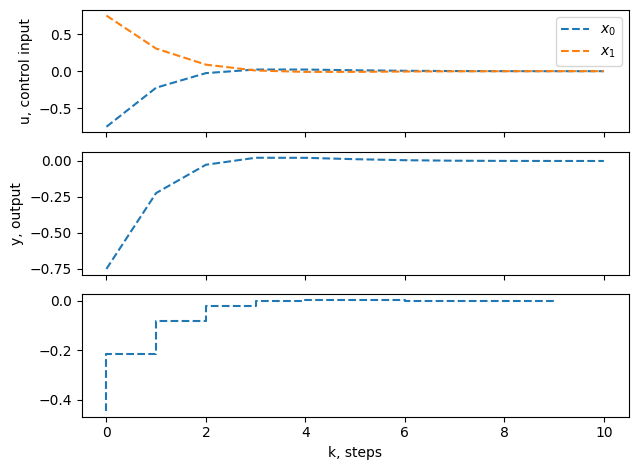

In [17]:
# plot u, x, and y on same x-axis (steps)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)

# X and Y are plot() since it's assumed this is 'linearly' affected by your controller
# X
for j in range(X_soln.shape[0]):
    ax1.plot(X_soln[j, :], '--', label=f'$x_{j}$')
if j > 0:
    ax1.legend()
ax1.set_ylabel('x, state')

# Y
for m in range(Y_soln.shape[0]):
    ax2.plot(Y_soln[m, :], '--', label=f'$y_{m}$')
if m > 0:
    ax2.legend()
ax2.set_ylabel('y, output')

# U --> step() as this is your controller knob
for i in range(U_soln.shape[0]):
    ax3.step(U_soln[i, :], '--', label=f'$u_{i}$')
if i > 0:
    ax3.legend()
ax1.set_ylabel('u, control input')

ax3.set_xlabel('k, steps')
plt.tight_layout()

In [16]:
# K.C. advice:
# another plot state --> x --> x[0], y --> x[1], exp. convergence to the middle

# warning solver error infeasible prob detected/large grad./infinity detected in closed-looped?
# ill-posed problem or typo~ in theory works but not implementing, more likely to be user-error
# debug: If not much known about the system, soften constraints to see if code runs